In [1]:
import os, sys
import logging
import glob
import math

import torch

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
#############

SRC_DIR = os.path.join(
    os.path.dirname(os.getcwd()), "protdiff"
)
assert os.path.isdir(SRC_DIR)
sys.path.append(SRC_DIR)
import datasets

BIN_DIR = os.path.join(
    os.path.dirname(os.getcwd()), "bin"
)
assert os.path.isdir(BIN_DIR)
sys.path.append(BIN_DIR)
from sample import sample

logging.basicConfig(level=logging.INFO)

Load in dataset of proteins and get the natural distribution of angles

In [2]:
cath_dset = datasets.CathConsecutiveAnglesDataset(split='train')
len(cath_dset)

INFO:root:Split train contains 18024/21668 examples
INFO:root:Removed structures with nan 18024 -> 12673
INFO:root:Length of angles: 39-499, mean 199.41324074804703


12673

In [3]:
select_by_attn = lambda x: x['angles'][torch.where(x['attn_mask'])]

cath_dset_values = torch.vstack([select_by_attn(cath_dset[i]) for i in range(len(cath_dset))])
cath_dset_values.shape

torch.Size([2527164, 4])

Generate some proteins

In [4]:
# Best model for linear variance schedule
# MODEL_DIR = "/home/t-kevinwu/projects/protein_diffusion/models/1000_timesteps_linear_variance_schedule_64_batch_size_0.0001_lr_0.5_gradient_clip"
# Best model for cosine variance schedule
# MODEL_DIR = "/home/t-kevinwu/projects/protein_diffusion/models/250_timesteps_cosine_variance_schedule_128_batch_size_0.0001_lr_0.5_gradient_clip"
# Model with radian loss
# MODEL_DIR = "/home/t-kevinwu/projects/protein_diffusion/models/results"
MODEL_DIR = "/home/t-kevinwu/projects/protein_diffusion/models/results_non_reg"

sampled_proteins = sample(
    64,
    cath_dset,
    glob.glob(os.path.join(MODEL_DIR, "lightning_logs/version_0/checkpoints/*.ckpt")).pop(),  # Get the single checkpoint
    os.path.join(MODEL_DIR, "training_args.json"),
)
len(sampled_proteins)

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmp7dpnt2k0
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmp7dpnt2k0/_remote_module_non_scriptable.py
INFO:root:Getting linear variance schedule with 1000 timesteps
INFO:root:Sampling of shape (64, 512, 4)


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

64

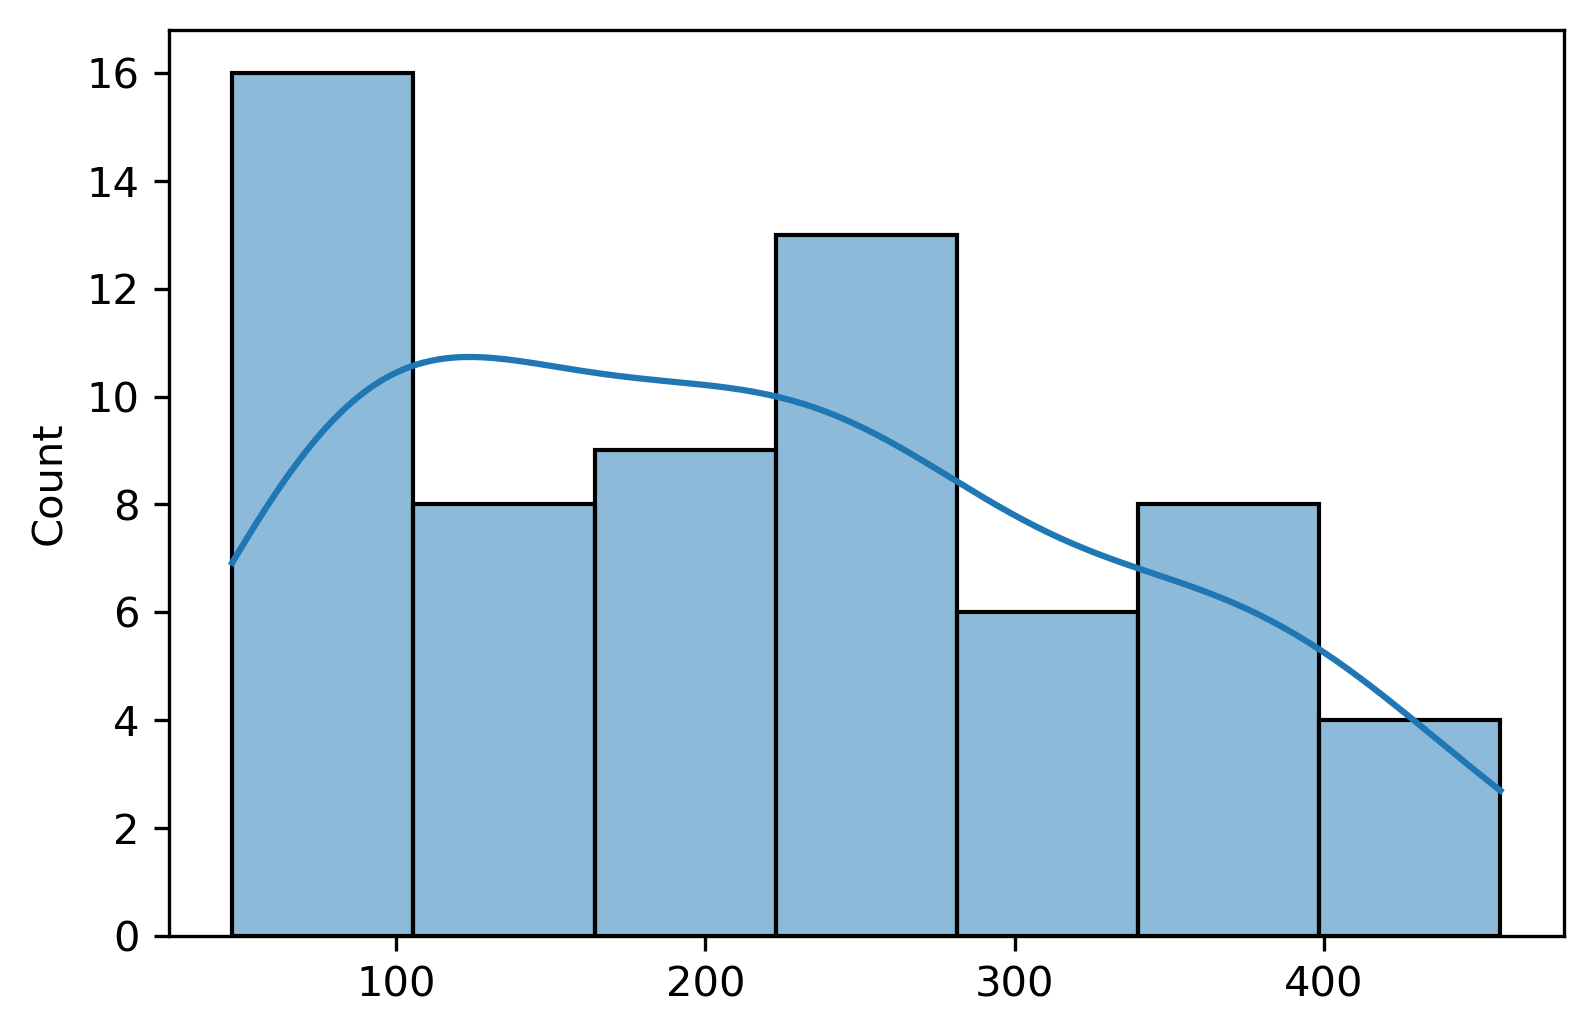

In [13]:
# Plot the distribution of lenghts of sampled proteins
fig, ax = plt.subplots(dpi=300)
sns.histplot([s.shape[0] for s in sampled_proteins], ax=ax, kde=True)
fig.show()

In [6]:
sampled_proteins_flat = torch.vstack(sampled_proteins) # Flatten to 1D
sampled_proteins_flat.shape

torch.Size([13785, 4])

In [7]:
sampled_proteins_flat

tensor([[ -8.9478,  20.4780,  41.6428,  -9.1402],
        [ -7.6172, -28.1070,  11.5962,  42.0110],
        [ 25.1090, -49.1216,   4.6726,  15.6626],
        ...,
        [ -1.6152, -24.6389,   7.1320,  50.4175],
        [ 17.9406, -79.5652,  21.7287,  20.3600],
        [ -7.0030,  17.5080,  18.5416,   6.1783]])

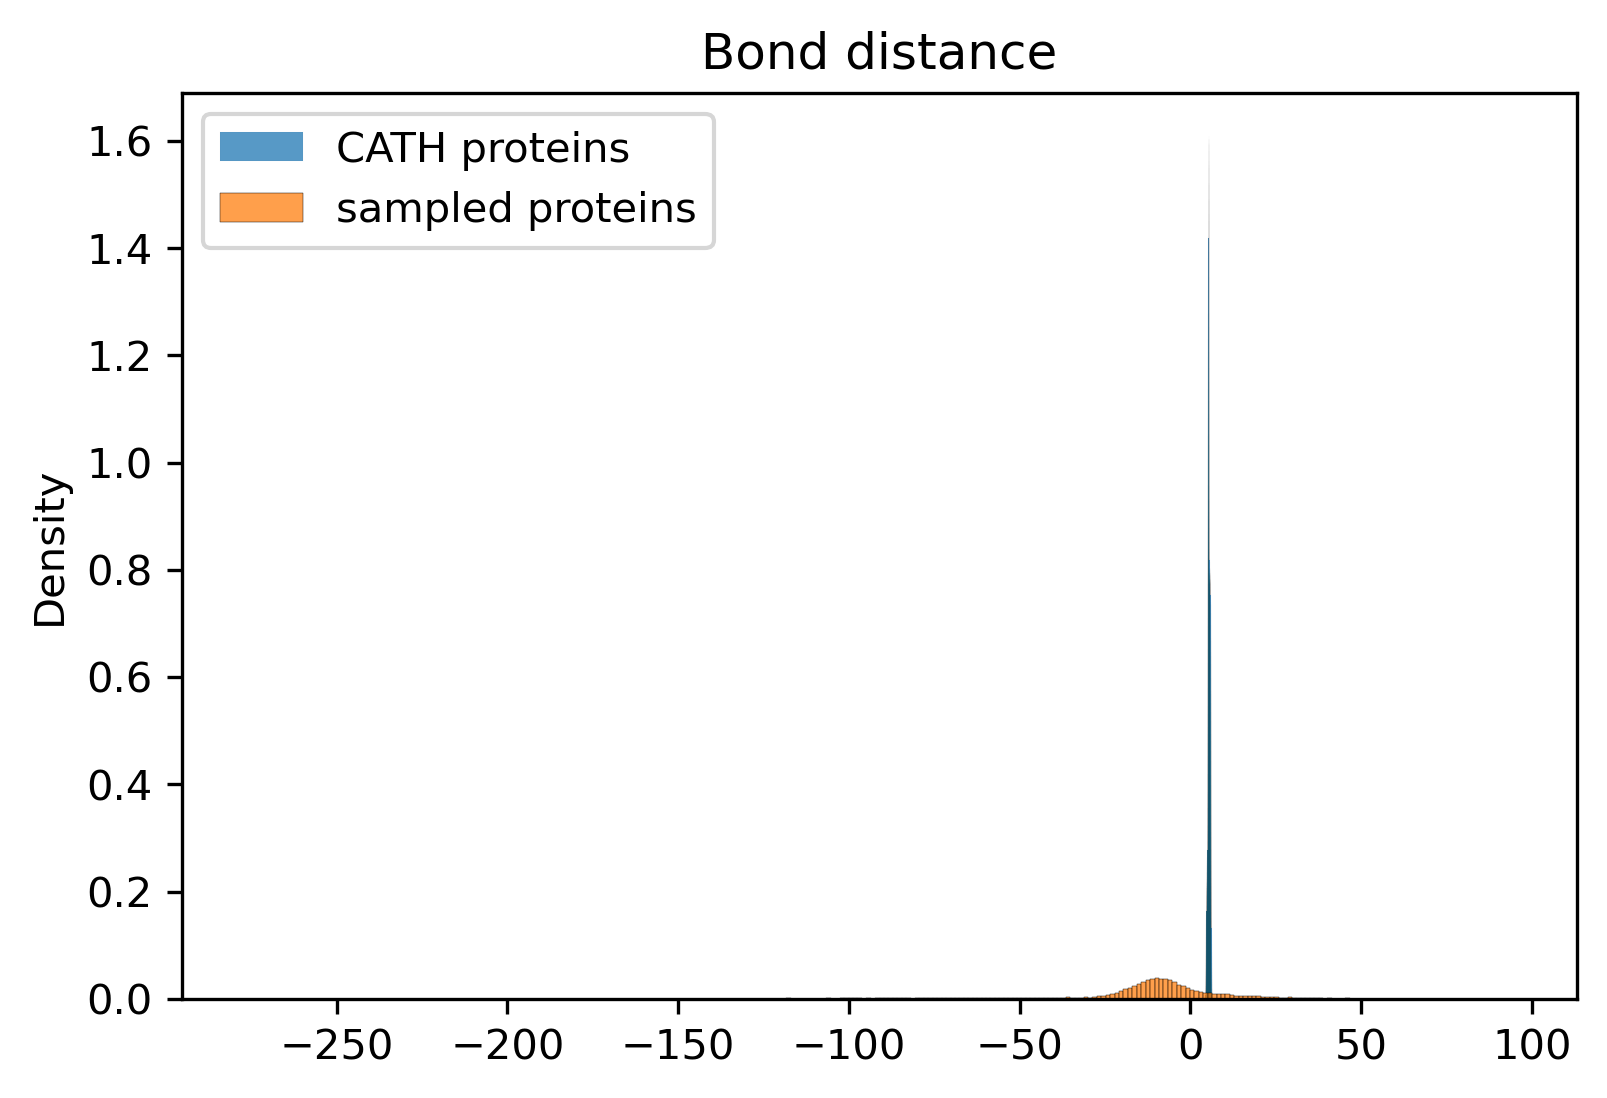

In [8]:
fig, ax = plt.subplots(dpi=300)
sns.histplot(cath_dset_values[:, 0], stat='density', label="CATH proteins", ax=ax, color='tab:blue')
sns.histplot(sampled_proteins_flat[:, 0], stat='density', label='sampled proteins', ax=ax, color='tab:orange')
ax.legend()
ax.set(
    # xlim=(0, 10),
    title="Bond distance",
)
fig.show()

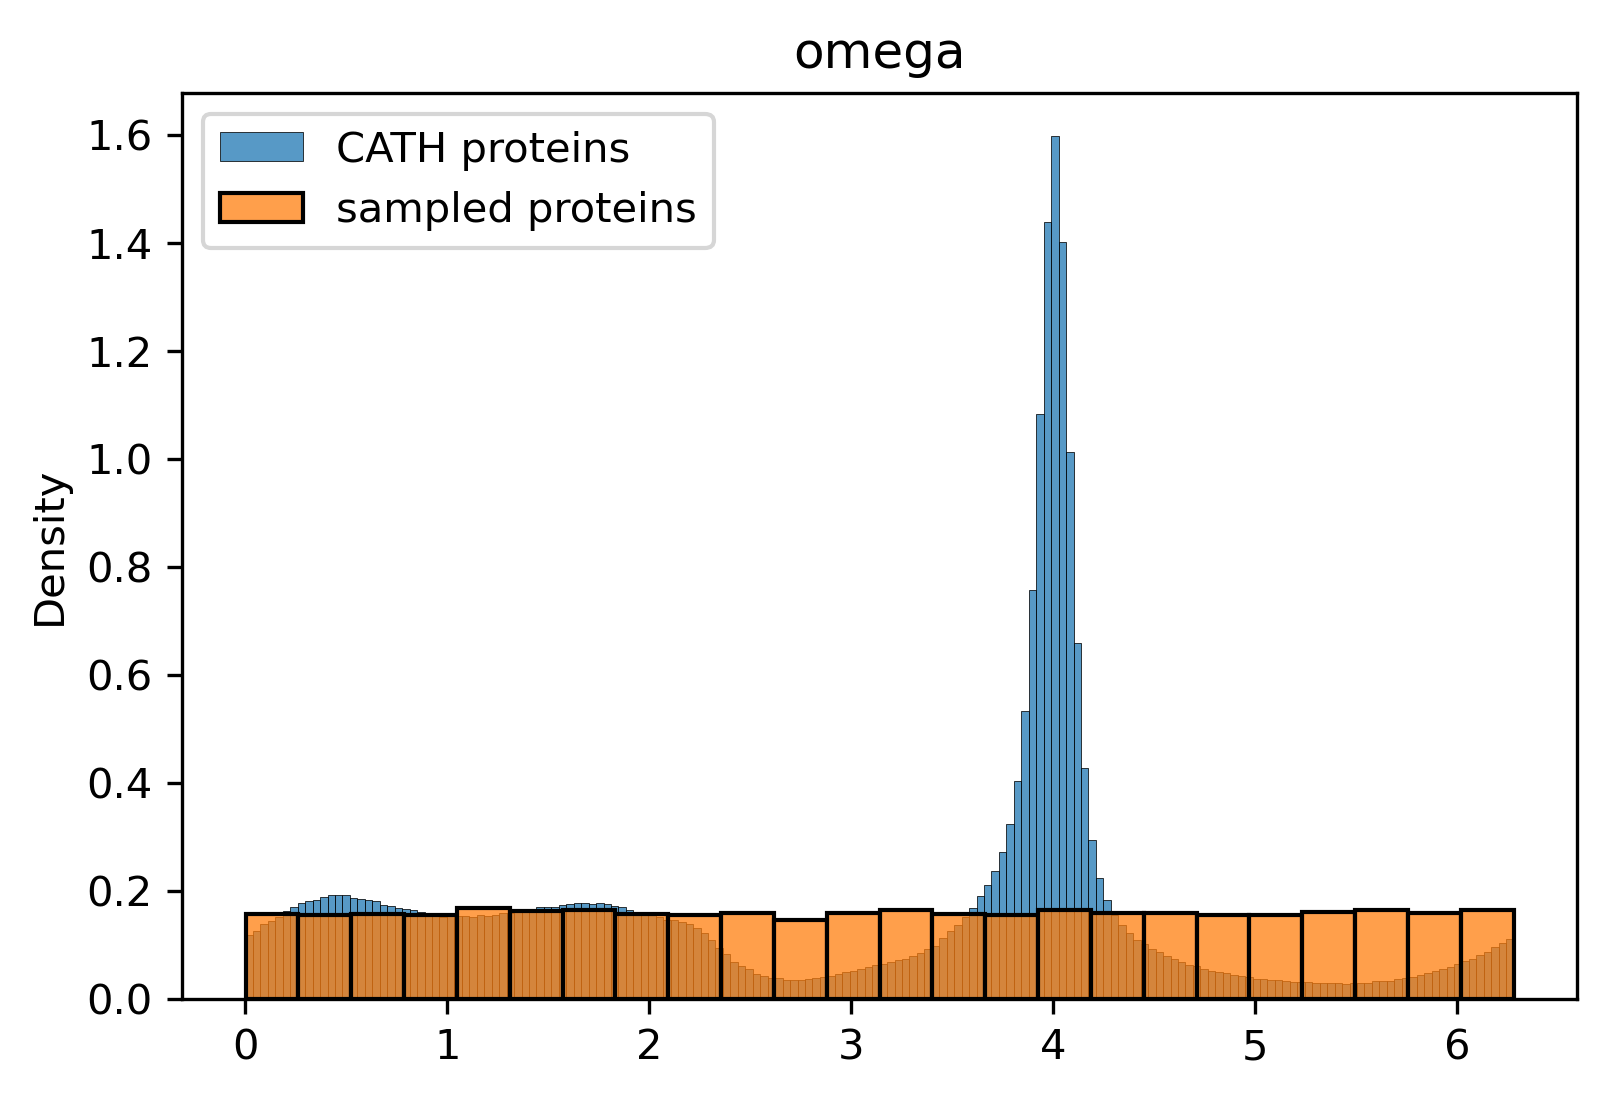

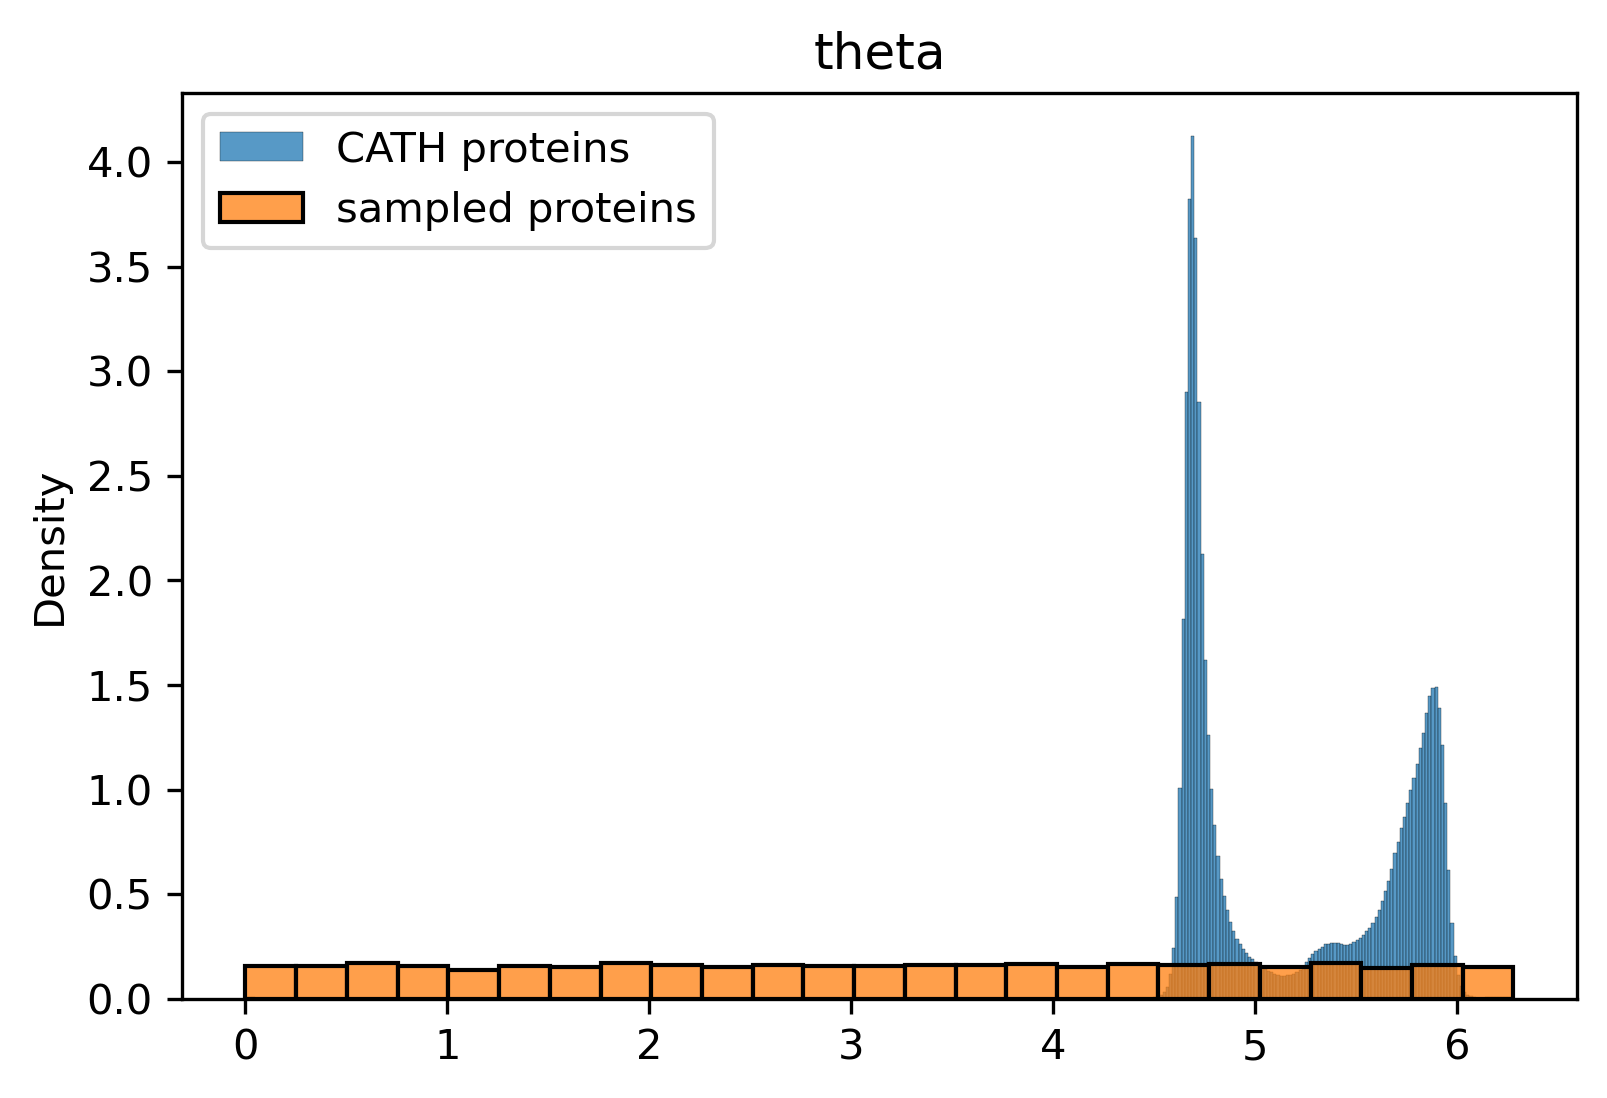

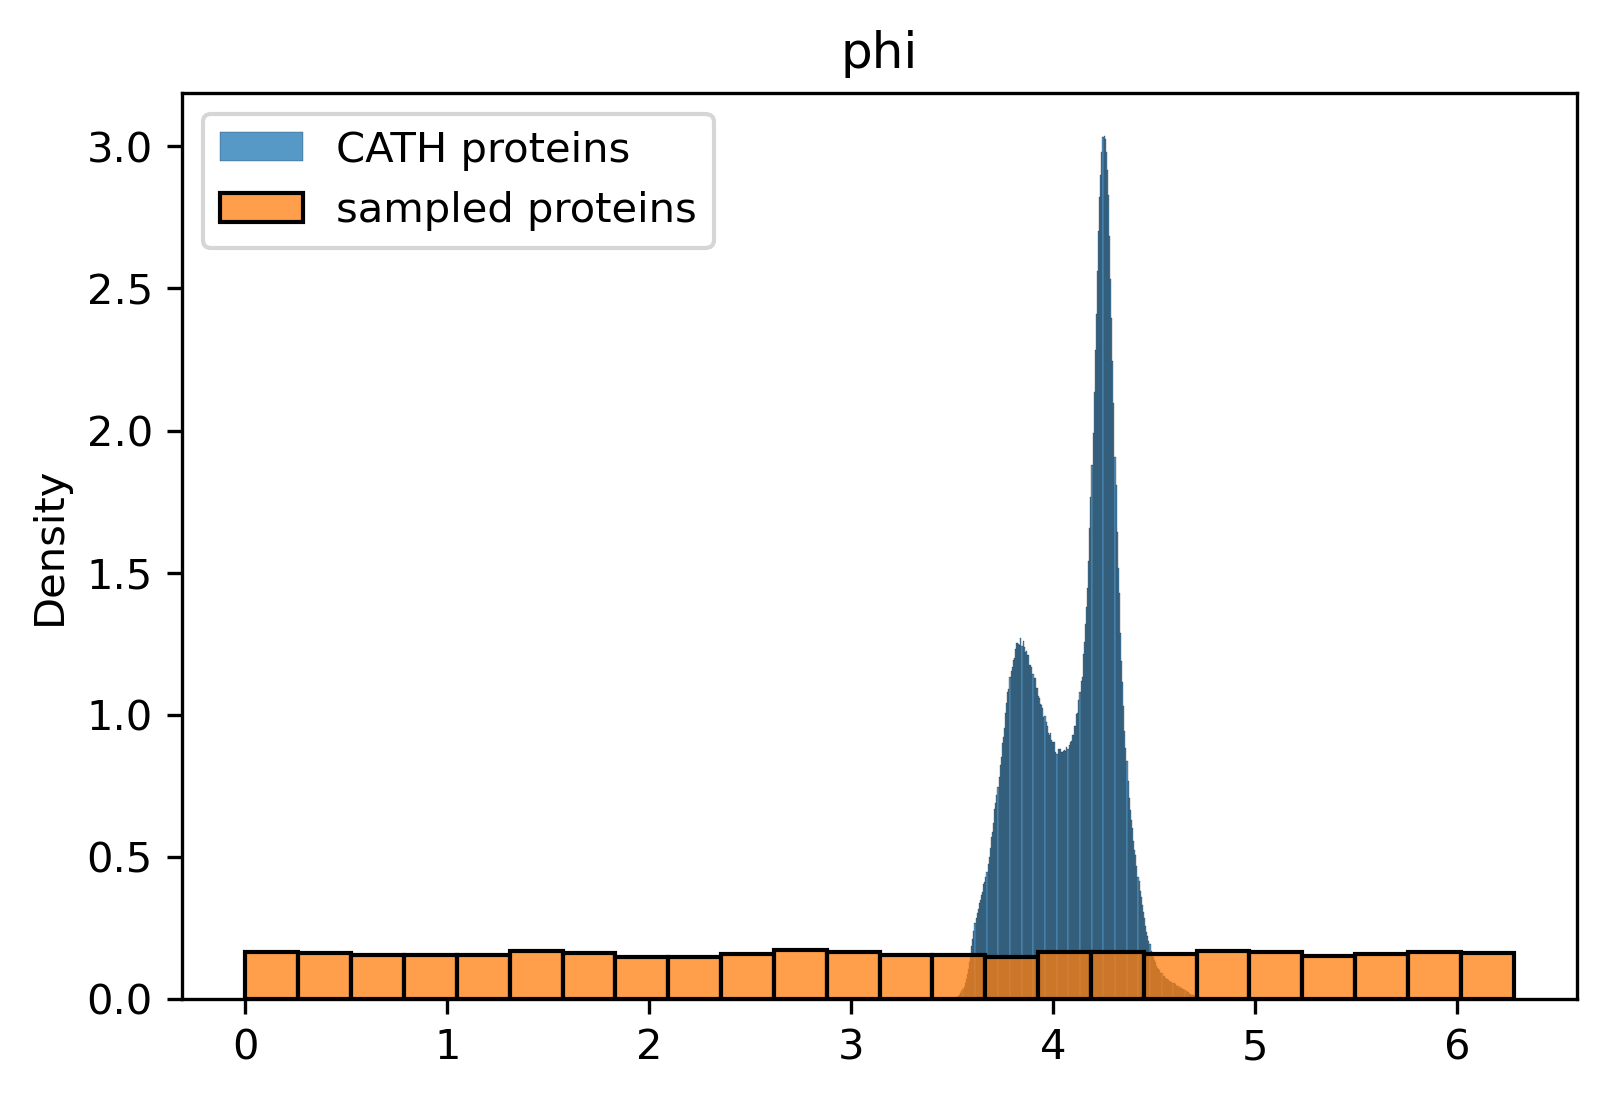

In [9]:
for i in range(1, 4):
    fig, ax = plt.subplots(dpi=300)
    sns.histplot(cath_dset_values[:, i], stat='density', label="CATH proteins", ax=ax, color='tab:blue')
    sns.histplot(sampled_proteins_flat[:, i] % (2 * np.pi), stat='density', label='sampled proteins', ax=ax, color='tab:orange')
    ax.legend()
    ax.set(
        # xlim=(-math.pi, math.pi),
        title=['omega', 'theta', 'phi'][i-1],
    )
    fig.show()